<a href="https://colab.research.google.com/github/nanlou888/Machine_Learning_MMA/blob/main/RSM8413_GroupAssignment1_Team12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**


**Problem Statement**

Predict if an auction on eBay would be competitive or non-competitive based on auctions that transacted on eBay.com during May-June 2004. Predicting whether an auction would be competitive or not will help eBay boost revenue and seller success by identifying non-competitive listings and provide recommendations to make them more attractive. This would improve seller retention, buyer engagement and overall positive market health.

**Notebook Structure**

Exploratory Data Analysis (EDA): Examining the dataset to understand key variables, spot data quality issues, and explore how features like sellerRating, Duration, OpenPrice, ClosePrice, Category, and endDay relate to competitiveness.

Data Preprocessing: Cleaning the data, encoding categorical variables, and scaling numerical features to prepare for modeling.

Model Development: Building and testing two main classification models:

K-Nearest Neighbors (KNN):

*   Baseline model and tuned model (via GridSearchCV).
*   Evaluation: k vs crossvalidation accuracy for best tuned model. Compare train, validate and test accuracy for best model.

Decision Trees (DT):

*   Baseline model with all features.
*   Baseline predictive model with all features except closingPrice.
*   Tuned model with only most important features.
*   Evaluation: Compare train and test accuracy across models to determine best model.

**Notebook Scope**

This notebook focuses on the EDA, data preparation and modelling steps. Charts are visible here too. We will be compiling the overall approach, findings and conclusions in a separate report along with the executive summary, aproach details and findings, along with model comparisons, recommendationsdata preparation and modeling steps, while all findings, results, and insights are presented in the accompanying written report.

In [ ]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import files

from sklearn.pipeline import Pipeline

!pip install dmba --quiet
import graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree
from dmba import classificationSummary

In [ ]:
uploaded = files.upload()

Saving ebayAuctions.xlsx to ebayAuctions (2).xlsx


# **EDA**

Perform univariate, bivariate and multivariate analysis

## **Load Dataset**

In [ ]:
#loading dataset
auctions_df = pd.read_excel("ebayAuctions.xlsx", sheet_name='eBay auctions')
auctions_df.head(5)

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [ ]:
#1972 entries, 8 columns, mix of categorical & numerical
auctions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [ ]:
#no missing values
auctions_df.isnull().values.any()

np.False_

In [ ]:
#convert object dtypes to category
auctions_df['Category'] = auctions_df['Category'].astype('category')
auctions_df['Currency'] = auctions_df['Currency'].astype('category')
auctions_df['endDay'] = auctions_df['endDay'].astype('category')

## **Univariate Analysis**

**exploring the target**

/tmp/ipython-input-392853665.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=auctions_df, x='Competitive?', palette='Set2')


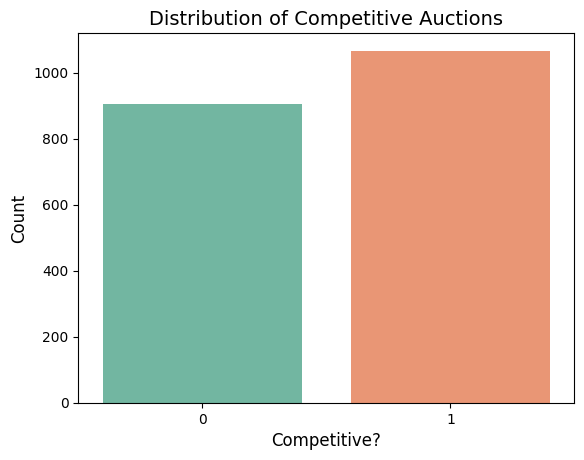

In [ ]:
sns.countplot(data=auctions_df, x='Competitive?', palette='Set2')

plt.title('Distribution of Competitive Auctions', fontsize=14)
plt.xlabel('Competitive?', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [ ]:
auctions_df["Competitive?"].value_counts()

,count
Competitive?,
1,1066
0,906


In [ ]:
# normalize
auctions_df["Competitive?"].value_counts(normalize = True) * 100

,proportion
Competitive?,
1,54.056795
0,45.943205


**exploring numerical variables**

In [ ]:
#statistical summary of numerical vars
auctions_df.describe()

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,3560.238337,6.486308,36.449087,12.926268,0.540568
std,5973.011033,2.052906,89.493858,38.856149,0.498478
min,0.000000,1.000000,0.010000,0.010000,0.000000
25%,595.000000,5.000000,4.907500,1.230000,0.000000
50%,1853.000000,7.000000,9.995000,4.500000,1.000000
75%,3380.000000,7.000000,28.000000,9.990000,1.000000
max,37727.000000,10.000000,999.000000,999.000000,1.000000


,0
sellerRating,"Axes(0.125,0.712609;0.168478x0.167391)"
Duration,"Axes(0.327174,0.712609;0.168478x0.167391)"
ClosePrice,"Axes(0.529348,0.712609;0.168478x0.167391)"
OpenPrice,"Axes(0.731522,0.712609;0.168478x0.167391)"


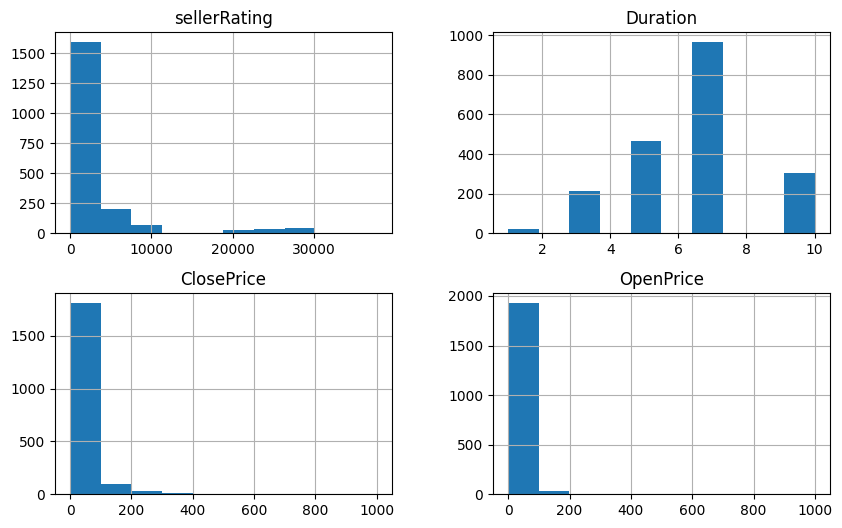

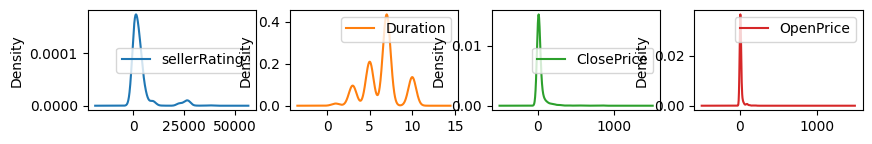

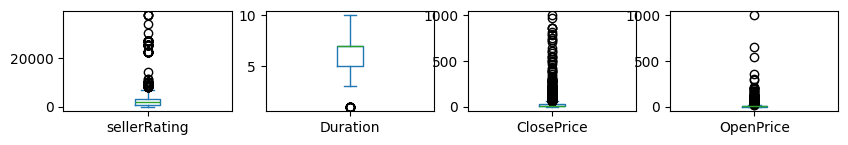

In [ ]:
num_vars = auctions_df.select_dtypes(include=['int64', 'float64']).columns.drop('Competitive?')
auctions_df[num_vars].hist(figsize=(10,6))

# Density Plots
auctions_df[num_vars].plot(figsize=(10,6), kind='density', subplots=True, layout=(4,4),
sharex=False)

# Box and Whisker Plots
auctions_df[num_vars].boxplot(figsize=(10,6))
plt.xticks(rotation=90)
auctions_df[num_vars].plot(figsize=(10,6), kind='box', subplots=True, layout=(4,4),
sharex=False, sharey=False)

**exploring categorical variables**

/tmp/ipython-input-914097829.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


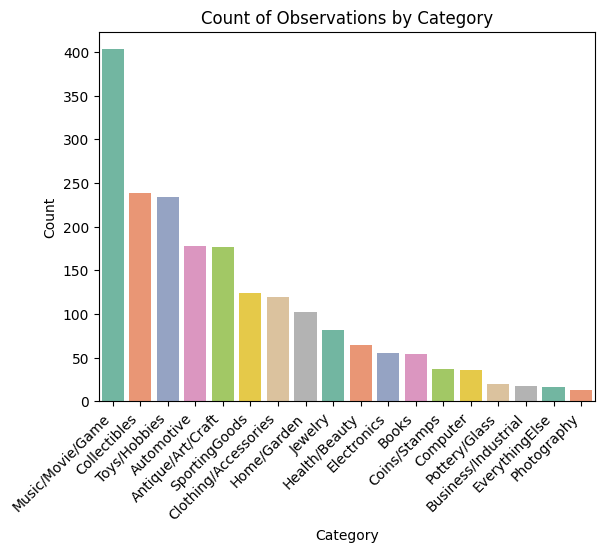

In [ ]:
plt.figure()
ax = sns.countplot(
    x="Category",
    data=auctions_df,
    order=auctions_df["Category"].value_counts().index,
    palette="Set2"
)
ax.set_title("Count of Observations by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

/tmp/ipython-input-412805788.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


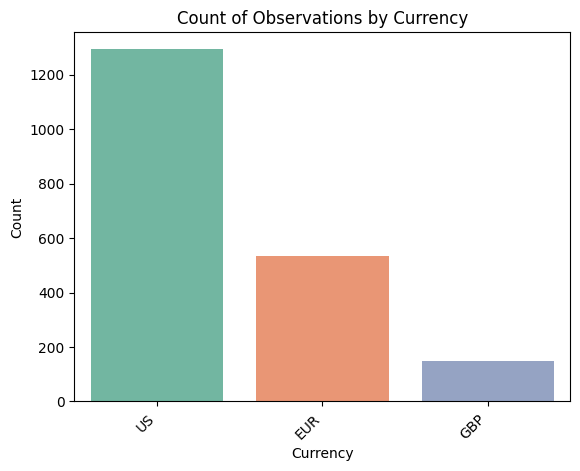

In [ ]:
plt.figure()
ax = sns.countplot(
    x="Currency",
    data=auctions_df,
    order=auctions_df["Currency"].value_counts().index,
    palette="Set2"
)
ax.set_title("Count of Observations by Currency")
ax.set_xlabel("Currency")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

/tmp/ipython-input-1106638510.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


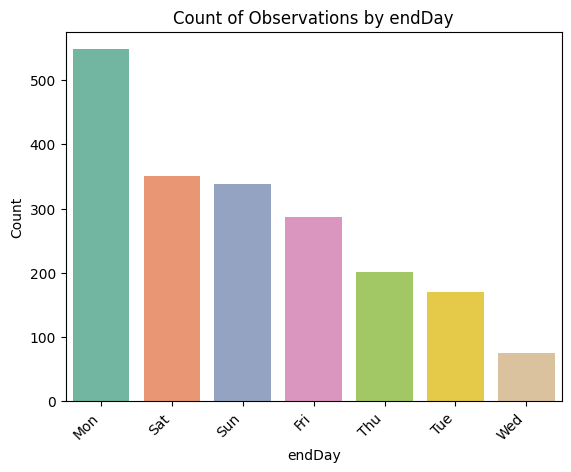

In [ ]:
plt.figure()
ax = sns.countplot(
    x="endDay",
    data=auctions_df,
    order=auctions_df["endDay"].value_counts().index,
    palette="Set2"
)
ax.set_title("Count of Observations by endDay")
ax.set_xlabel("endDay")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

## **Bivariate Analysis**

**Exploring relationship b/w categorical predictors and response**

Text(0.5, 0, 'Category')

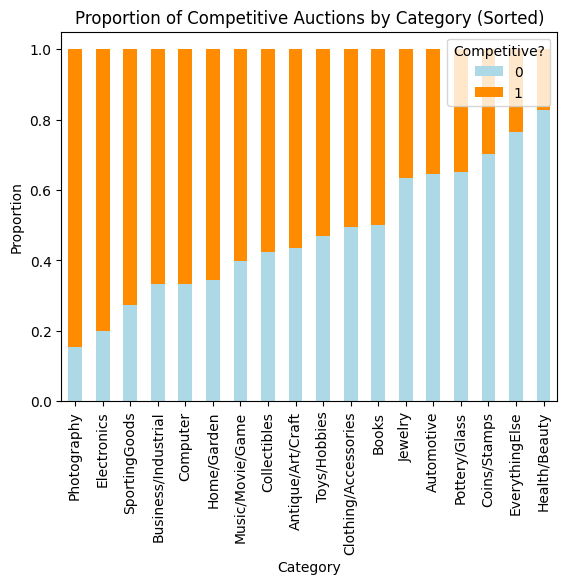

In [ ]:
auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["Category"],margins=False)
auctions_df_crosstab = auctions_df_crosstab.transpose()

#Normalize Values
auctions_df_crosstab= auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)
#auctions_df_crosstab.plot(kind = 'bar', stacked = True)

# Sort categories by proportion of Competitive=1 (column name might be 1)
auctions_df_crosstab = auctions_df_crosstab.sort_values(by=1, ascending=False)

# Plot
ax = auctions_df_crosstab.plot(kind="bar", stacked=True, color=["lightblue", "darkorange"])
ax.set_title("Proportion of Competitive Auctions by Category (Sorted)")
ax.set_ylabel("Proportion")
ax.set_xlabel("Category")

(array([0, 1, 2]), [Text(0, 0, 'GBP'), Text(1, 0, 'EUR'), Text(2, 0, 'US')])

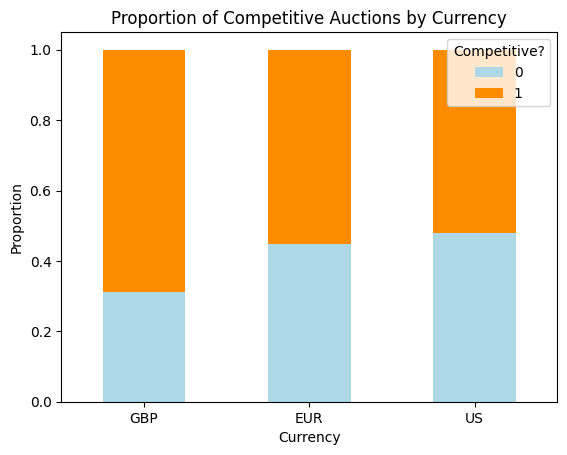

In [ ]:
auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["Currency"],margins=False)
auctions_df_crosstab = auctions_df_crosstab.transpose()
auctions_df_crosstab = auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)

# Sort categories by proportion of Competitive=1
auctions_df_crosstab = auctions_df_crosstab.sort_values(by=1, ascending=False)
# Plot
ax = auctions_df_crosstab.plot(kind="bar", stacked=True, color=["lightblue", "darkorange"])
ax.set_title("Proportion of Competitive Auctions by Currency")
ax.set_ylabel("Proportion")
ax.set_xlabel("Currency")
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Thu'),
  Text(2, 0, 'Tue'),
  Text(3, 0, 'Sun'),
  Text(4, 0, 'Wed'),
  Text(5, 0, 'Fri'),
  Text(6, 0, 'Sat')])

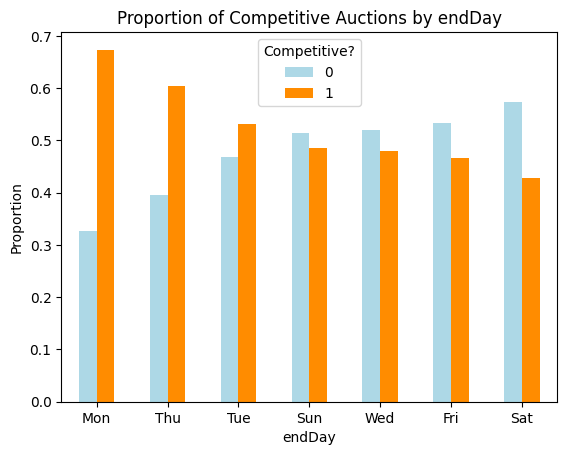

In [ ]:

auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["endDay"],margins=False)
auctions_df_crosstab = auctions_df_crosstab.transpose()
auctions_df_crosstab = auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)

# Sort categories by proportion of Competitive=1
auctions_df_crosstab = auctions_df_crosstab.sort_values(by=1, ascending=False)
# Plot
ax = auctions_df_crosstab.plot(kind="bar", color=["lightblue", "darkorange"])
ax.set_title("Proportion of Competitive Auctions by endDay")
ax.set_ylabel("Proportion")
ax.set_xlabel("endDay")
plt.xticks(rotation=0)

**Exploring relationship b/w numerical predictors and response**

In [ ]:
# Exploring relationship b/w numerical predictors and response

import plotly.express as px
#fig = px.histogram(auctions_df, x="sellerRating", color="Competitive?", barnorm='fraction')
#fig.data = fig.data[::-1]
#fig.show()

fig = px.histogram(
    auctions_df,
    x="sellerRating",
    color="Competitive?",
    barnorm='fraction',
    barmode="group",
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))

fig.update_layout(title="Normalized Histogram of sellerRating",
                  xaxis_title="sellerRating",
                  yaxis_title="Percent",
                  xaxis=dict(
                      tickmode='linear',
                      dtick=2000,   # step size between ticks
                      tickangle=45
                      )
                  )

fig.show()


In [ ]:
fig = px.histogram(
    auctions_df,
    x="Duration",
    color="Competitive?",
    barnorm='fraction',
    barmode="group"
)
fig.update_traces(marker=dict(line=dict(width=1, color='black')))

fig.update_layout(title="Normalized Histogram of Duration",
                  xaxis_title="Duration",
                  yaxis_title="Percent")
fig.show()

In [ ]:
fig = px.histogram(
    auctions_df,
    x="OpenPrice",
    color="Competitive?",
    barnorm='fraction',
    barmode="group",
    nbins=30
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))

fig.update_layout(title="Normalized Histogram of OpenPrice",
                  xaxis_title="OpenPrice",
                  yaxis_title="Percent")
fig.show()

In [ ]:
fig = px.histogram(
    auctions_df,
    x="ClosePrice",
    color="Competitive?",
    barnorm='fraction',
    barmode="group",
    nbins=30
)

fig.update_traces(marker=dict(line=dict(width=1, color='black')))
fig.update_layout(
    title="Normalized Histogram of ClosePrice",
    xaxis_title="ClosePrice",
    yaxis_title="Percent",
    xaxis=dict(
        tickmode='linear',  # Linear scale for axis ticks
        tick0=0,
        dtick=100,          # Show one tick every 100 units
        tickangle=45        # Rotate tick labels to avoid overlapping
    )
)

fig.show()

## **Multivariate Analysis**

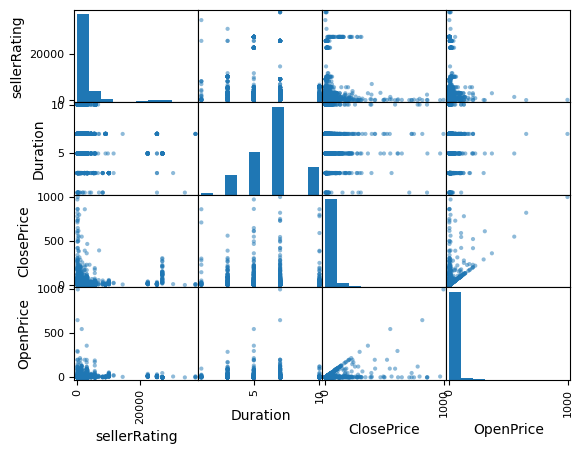

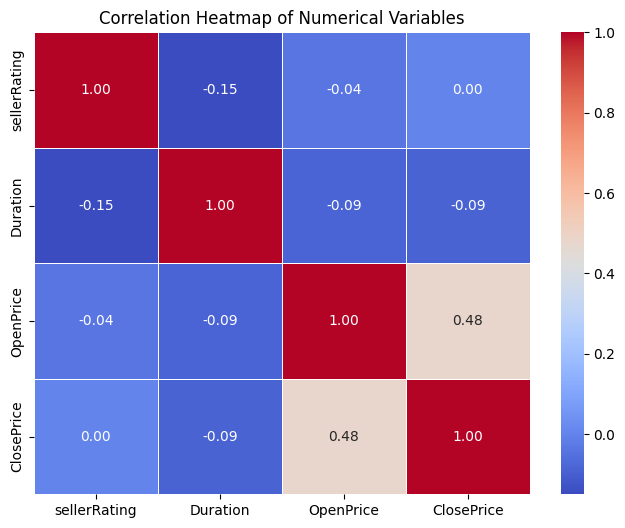

In [ ]:
# Scatterplot
from pandas.plotting import scatter_matrix
num_predictors = auctions_df.drop(columns=["Competitive?"])
scatter_matrix(num_predictors, diagonal='hist')
plt.show()

#Heat map
num_vars = ["sellerRating", "Duration", "OpenPrice", "ClosePrice"]
corr = auctions_df[num_vars].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

# **Data Processing**

Convert categorical variables to numerical via one-hot encoding, bin Category column to 6 categories (top 5 and all others as "Other"), split into train & test (80%-20%), scale train data and test data

In [ ]:
def preprocess_ebay_auctions(df: pd.DataFrame = None, auctions_df: str = None, target_col: str = "Competitive?"):
    print("=== Starting eBay Auctions Data Preprocessing ===")

    # Load data
    if df is None and auctions_df:
        df = pd.read_excel(auctions_df, sheet_name="eBay auctions")
    elif df is None:
        raise ValueError("Please provide either a DataFrame or file path")

    print(f"Initial data shape: {df.shape}")

    # Handling Category column
    if "Category" in df.columns:
        top_n = 5
        top_categories = df["Category"].value_counts().nlargest(top_n).index
        print(f"Top {top_n} categories kept: {list(top_categories)}")
        df["Category"] = df["Category"].where(df["Category"].isin(top_categories), other="Other")

    # Identifying categorical and numerical columns
    cat_cols = [col for col in df.select_dtypes(include=["object", "category"]).columns if col != target_col]
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.difference([target_col])
    print(f"Categorical columns: {cat_cols}")
    print(f"Numerical columns: {list(num_cols)}")

    # One-hot encoding categorical variables
    print("Applying one-hot encoding...")
    encoder = OneHotEncoder(drop=None, sparse_output=False, handle_unknown="ignore")
    cat_encoded = pd.DataFrame(encoder.fit_transform(df[cat_cols]))
    cat_encoded.columns = encoder.get_feature_names_out(cat_cols)
    cat_encoded.index = df.index
    print(f"Encoded {len(cat_cols)} categorical columns into {cat_encoded.shape[1]} dummy variables.")

    # Combine numeric, encoded categorical, and target columns
    df_encoded = pd.concat([df[num_cols], cat_encoded, df[target_col]], axis=1)
    print(f"Data after encoding shape: {df_encoded.shape}")

    # Split dataset into train and test sets (80/20 stratified)
    print("Splitting into train (80%) and test (20%) sets...")
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print("Label distribution check:")
    print("Train:", y_train.value_counts(normalize=True).round(2).to_dict())
    print("Test :", y_test.value_counts(normalize=True).round(2).to_dict())

    # Scale numerical columns using train statistics
    print("Scaling numerical columns...")
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    print("Scaling complete.")

    # Recombine scaled data with target labels
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    print(f"Final train shape: {train_df.shape}, test shape: {test_df.shape}")

    print("=== Preprocessing Completed Successfully ===")
    data_processed_dict = {
        "train_df": train_df,
        "test_df": test_df,
        "encoder": encoder,
        "scaler": scaler,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "cat_cols": cat_cols,
        "num_cols": num_cols
    }
    return data_processed_dict
# train_df, test_df, encoder, scaler = preprocess_ebay_auctions(auctions_df="ebayAuctions.xlsx")
data_processed_dict = preprocess_ebay_auctions(auctions_df="ebayAuctions.xlsx")

=== Starting eBay Auctions Data Preprocessing ===
Initial data shape: (1972, 8)
Top 5 categories kept: ['Music/Movie/Game', 'Collectibles', 'Toys/Hobbies', 'Automotive', 'Antique/Art/Craft']
Categorical columns: ['Category', 'Currency', 'endDay']
Numerical columns: ['ClosePrice', 'Duration', 'OpenPrice', 'sellerRating']
Applying one-hot encoding...
Encoded 3 categorical columns into 16 dummy variables.
Data after encoding shape: (1972, 21)
Splitting into train (80%) and test (20%) sets...
Train shape: (1577, 20), Test shape: (395, 20)
Label distribution check:
Train: {1: 0.54, 0: 0.46}
Test : {1: 0.54, 0: 0.46}
Scaling numerical columns...
Scaling complete.
Final train shape: (1577, 21), test shape: (395, 21)
=== Preprocessing Completed Successfully ===


# **Model Experimentation - KNN**

***Approach***

First build baseline KNN model, then tune model for all features and tune model for all features except closePrice (for making live predictions)

# **Baseline Model - KNN**

In [ ]:
#get scaled train & test data post data preprocessing
X_train, X_test, y_train, y_test = data_processed_dict["X_train"], data_processed_dict["X_test"], data_processed_dict["y_train"], data_processed_dict["y_test"]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1577, 20), (395, 20), (1577,), (395,))


Train Accuracy: 0.8224
Test Accuracy:  0.7392
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       181
           1       0.78      0.72      0.75       214

    accuracy                           0.74       395
   macro avg       0.74      0.74      0.74       395
weighted avg       0.74      0.74      0.74       395



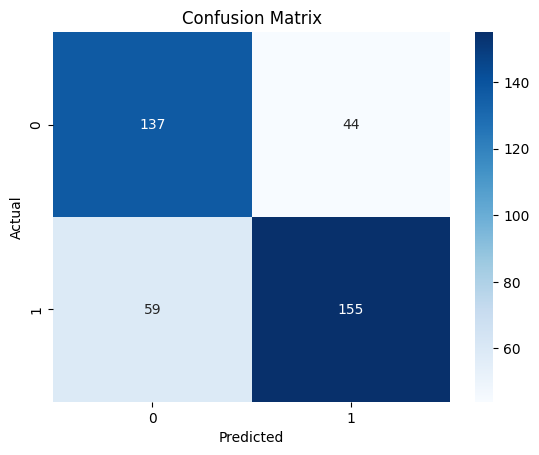

In [ ]:
# train & predict
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

#Compare train vs test accuracy
train_acc = knn_classifier.score(X_train, y_train)
test_acc = knn_classifier.score(X_test, y_test)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

#get classification report
print(classification_report(y_test, y_pred))

# get confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



# **Tuned Model - KNN**

In [ ]:

#cross validation (10-fold) & grid search

param_grid = {'knn__n_neighbors': range(1, 21),'knn__weights': ['uniform', 'distance'],'knn__metric': ['euclidean', 'manhattan']}
pipe = Pipeline([('knn', KNeighborsClassifier())])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv=cv)
grid.fit(X_train, y_train)

print("Grid Search Complete")
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_, 4))

Grid Search Complete
Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Best CV Accuracy: 0.7755


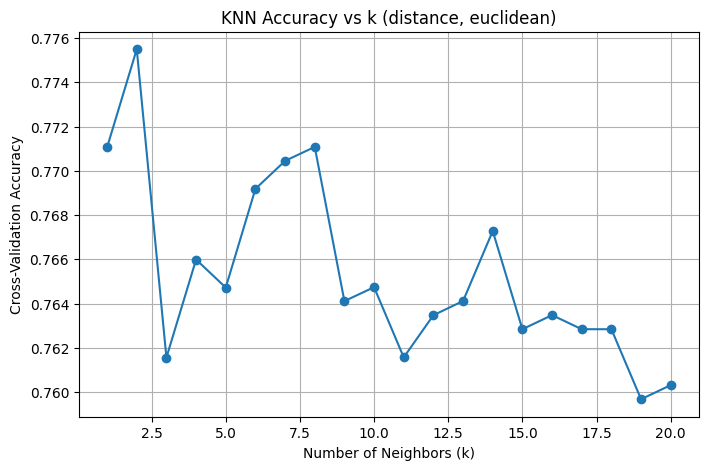

In [ ]:
#plot k vs mean CV accuracy
results = pd.DataFrame(grid.cv_results_)
best_w = grid.best_params_['knn__weights']
best_m = grid.best_params_['knn__metric']
subset = results[(results['param_knn__weights'] == best_w) & (results['param_knn__metric'] == best_m)]

plt.figure(figsize=(8,5))
plt.plot(subset['param_knn__n_neighbors'], subset['mean_test_score'], marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title(f"KNN Accuracy vs k ({best_w}, {best_m})")
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74       181
           1       0.77      0.80      0.79       214

    accuracy                           0.76       395
   macro avg       0.76      0.76      0.76       395
weighted avg       0.76      0.76      0.76       395


Train Accuracy: 0.9937
Test Accuracy:  0.7646

Confusion Matrix:


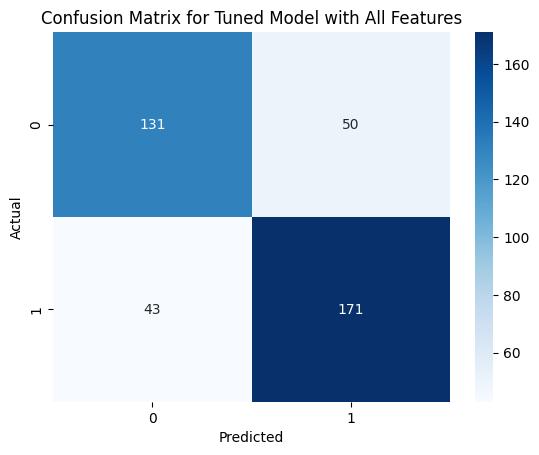

In [ ]:
#predict with test and get test results
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Compare train vs test accuracy
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Tuned Model with All Features")
plt.show()

# **Tuned Model - KNN without closingPrice**

In [ ]:

#drop closing price
X_train1 = X_train.drop(columns=["ClosePrice"], inplace=False)
X_test1  = X_test.drop(columns=["ClosePrice"], inplace=False)

#cross validation (10-fold) & grid search
param_grid = {'knn__n_neighbors': range(1, 21),'knn__weights': ['uniform', 'distance'],'knn__metric': ['euclidean', 'manhattan']}
pipe = Pipeline([('knn', KNeighborsClassifier())])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='accuracy', cv=cv)
grid.fit(X_train1, y_train)

print("Grid Search Complete")
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_, 4))

Grid Search Complete
Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 20, 'knn__weights': 'distance'}
Best CV Accuracy: 0.6886


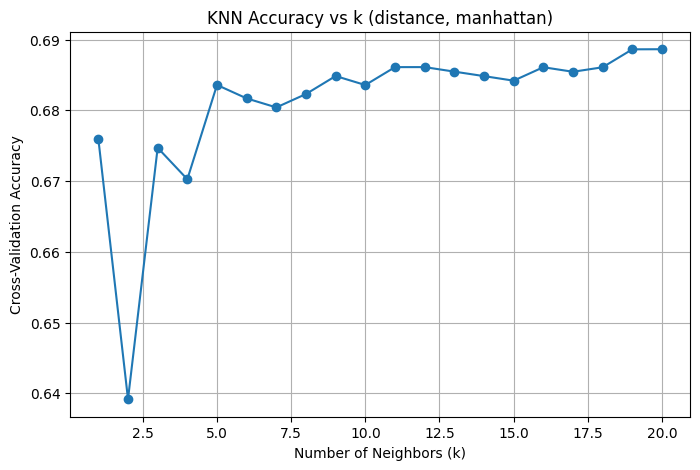

In [ ]:
#plot k vs mean CV accuracy
results = pd.DataFrame(grid.cv_results_)
best_w = grid.best_params_['knn__weights']
best_m = grid.best_params_['knn__metric']
subset = results[(results['param_knn__weights'] == best_w) & (results['param_knn__metric'] == best_m)]

plt.figure(figsize=(8,5))
plt.plot(subset['param_knn__n_neighbors'], subset['mean_test_score'], marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title(f"KNN Accuracy vs k ({best_w}, {best_m})")
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       181
           1       0.70      0.73      0.72       214

    accuracy                           0.69       395
   macro avg       0.68      0.68      0.68       395
weighted avg       0.69      0.69      0.69       395


Train Accuracy: 0.9182
Test Accuracy:  0.6861

Confusion Matrix:


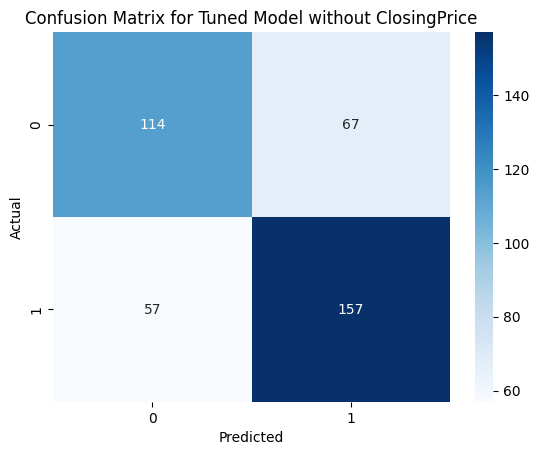

In [ ]:
#predict with test and get test results
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Compare train vs test accuracy
train_acc = best_model.score(X_train1, y_train)
test_acc = best_model.score(X_test1, y_test)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Tuned Model without ClosingPrice")
plt.show()

# **Model Experimentation - Decision Trees**

**Approach**

1. **Baseline Exploratory Model** – Trained with all predictors (including *ClosePrice*) to explore variable importance and overall auction competitiveness patterns.  
2. **Baseline Predictive Model** – Excludes *ClosePrice* to reflect real-world prediction scenarios, where future closing prices are unknown.  
3. **Tuned Model** – Uses only the top predictors (*OpenPrice*, *SellerRating*) and applies **GridSearchCV** to fine-tune hyperparameters for improved generalization and model stability.


## **Baseline Exploratory Model**

In [ ]:
X_train = data_processed_dict["X_train"]
X_test  = data_processed_dict["X_test"]
y_train = data_processed_dict["y_train"]
y_test  = data_processed_dict["y_test"]

In [ ]:
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=50)
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=50, random_state=1)

In [ ]:
# Measure of Performance
from sklearn.metrics import confusion_matrix
from dmba import classificationSummary

y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)

print("\nClassification Summary (Train):")
classificationSummary(y_train, y_train_pred)

print("\nClassification Summary (Test):")
classificationSummary(y_test, y_test_pred)


Classification Summary (Train):
Confusion Matrix (Accuracy 0.8351)

       Prediction
Actual   0   1
     0 655  70
     1 190 662

Classification Summary (Test):
Confusion Matrix (Accuracy 0.8076)

       Prediction
Actual   0   1
     0 156  25
     1  51 163


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Non-Competitive', 'Competitive']))

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Non-Competitive', 'Competitive']))

Classification Report (Train):
                 precision    recall  f1-score   support

Non-Competitive       0.78      0.90      0.83       725
    Competitive       0.90      0.78      0.84       852

       accuracy                           0.84      1577
      macro avg       0.84      0.84      0.84      1577
   weighted avg       0.84      0.84      0.84      1577

Classification Report (Test):
                 precision    recall  f1-score   support

Non-Competitive       0.75      0.86      0.80       181
    Competitive       0.87      0.76      0.81       214

       accuracy                           0.81       395
      macro avg       0.81      0.81      0.81       395
   weighted avg       0.82      0.81      0.81       395



In [ ]:
# Explore feature importance
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))

OpenPrice                     0.477810
ClosePrice                    0.462253
sellerRating                  0.059937
Duration                      0.000000
Category_Antique/Art/Craft    0.000000
Category_Automotive           0.000000
Category_Collectibles         0.000000
Category_Music/Movie/Game     0.000000
Category_Other                0.000000
Category_Toys/Hobbies         0.000000
Currency_EUR                  0.000000
Currency_GBP                  0.000000
Currency_US                   0.000000
endDay_Fri                    0.000000
endDay_Mon                    0.000000
endDay_Sat                    0.000000
endDay_Sun                    0.000000
endDay_Thu                    0.000000
endDay_Tue                    0.000000
endDay_Wed                    0.000000
dtype: float64


In [ ]:
# Visualization of the Decision Tree
feature_names = list(X_train.columns)
class_names = list(map(str, list(y_train.unique())))

text_representation = tree.export_text(clf, feature_names = feature_names)
print(text_representation)

|--- OpenPrice <= -0.24
|   |--- ClosePrice <= -0.37
|   |   |--- OpenPrice <= -0.31
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  -0.31
|   |   |   |--- ClosePrice <= -0.38
|   |   |   |   |--- ClosePrice <= -0.40
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ClosePrice >  -0.40
|   |   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  -0.38
|   |   |   |   |--- class: 0
|   |--- ClosePrice >  -0.37
|   |   |--- OpenPrice <= -0.27
|   |   |   |--- class: 1
|   |   |--- OpenPrice >  -0.27
|   |   |   |--- class: 1
|--- OpenPrice >  -0.24
|   |--- ClosePrice <= -0.30
|   |   |--- OpenPrice <= -0.21
|   |   |   |--- class: 0
|   |   |--- OpenPrice >  -0.21
|   |   |   |--- ClosePrice <= -0.34
|   |   |   |   |--- OpenPrice <= -0.20
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- OpenPrice >  -0.20
|   |   |   |   |   |--- class: 0
|   |   |   |--- ClosePrice >  -0.34
|   |   |   |   |--- OpenPrice <= -0.13
|   |   |   |   |   |--- class: 0
|   |   |   |   |--

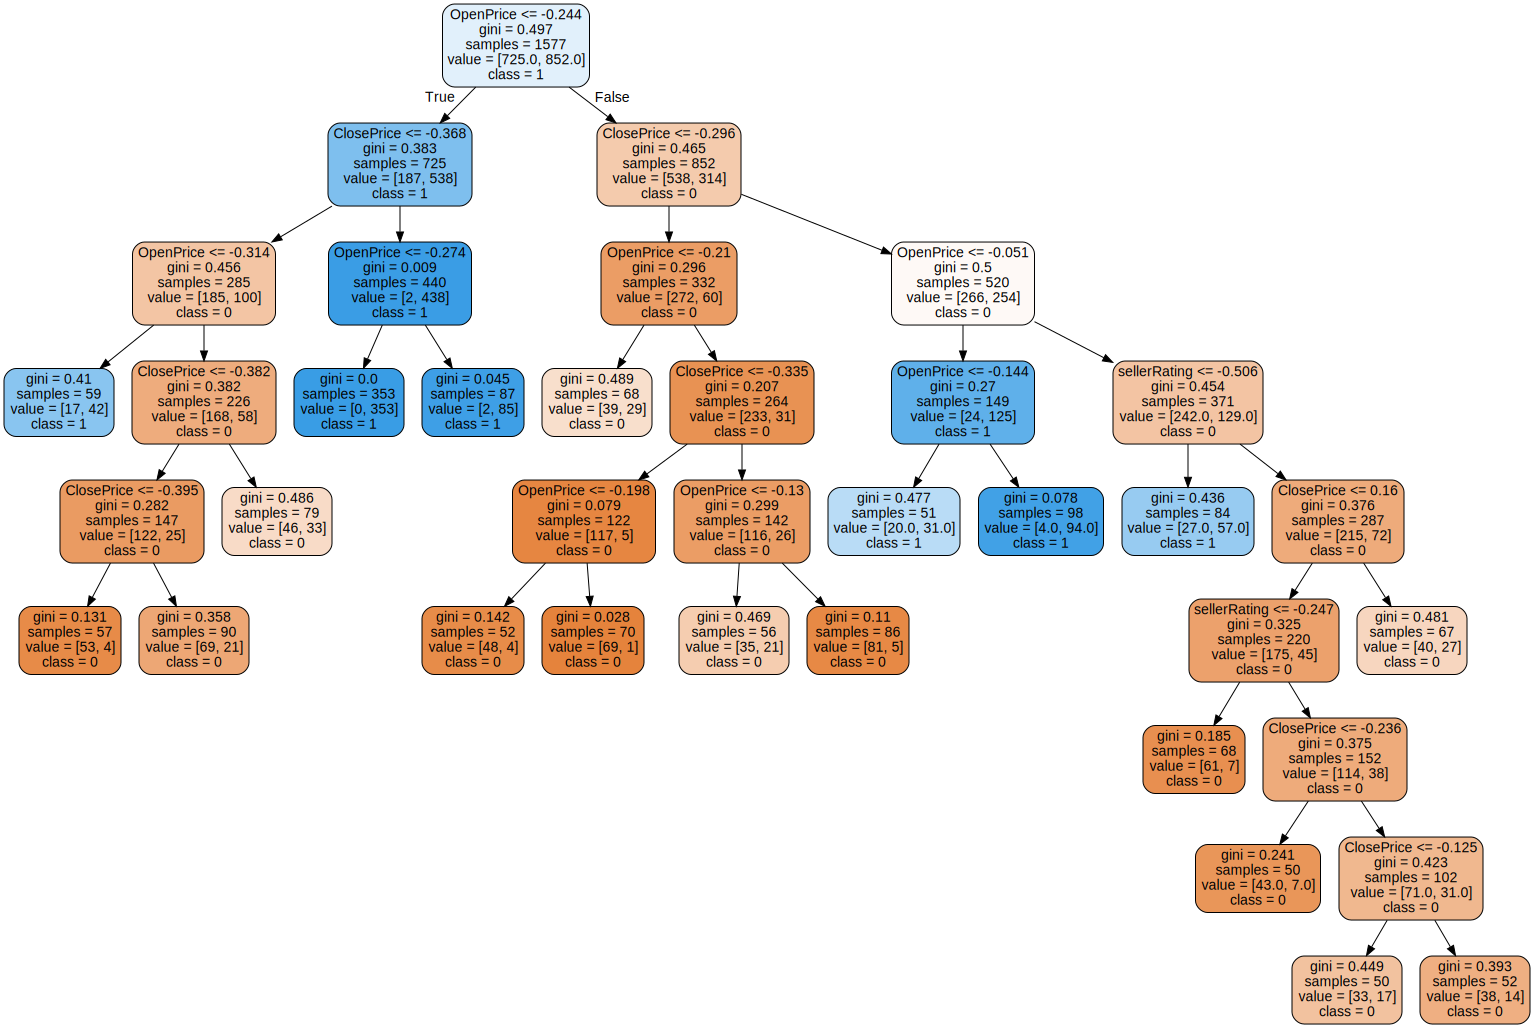

In [ ]:
dot_data = export_graphviz(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    rounded=True,
    filled=True
)

# Visualize in Colab
graph = graphviz.Source(dot_data)
graph.render("fullClassTree")  # saves PDF by default
graph  # display inline

## **Baseline Predictive Model**

The previous model seems to perform very well in terms of accuracy, however, in practice to predict the competitiveness of **new auctions**, we **cannot use `ClosePrice`** because it is only observed after the auction ends. Including it in the model would constitute “cheating” for future predictions. Therefore, we now retrained the decision tree by dropping `ClosePrice`, and tune our model based on this predictive model.

In [ ]:
X_train_pred = X_train.drop(columns=["ClosePrice"], inplace=False)
X_test_pred = X_test.drop(columns=["ClosePrice"], inplace=False)

In [ ]:
clf_2 = DecisionTreeClassifier(random_state=1, min_samples_leaf=50)
clf_2.fit(X_train_pred, y_train)

y_pred_1 = clf_2.predict(X_train_pred)

print("\nClassification Summary (Train):")
classificationSummary(y_train, y_pred_1)

y_pred_2 = clf_2.predict(X_test_pred)

print("\nClassification Summary (Test):")
classificationSummary(y_test, y_pred_2)


Classification Summary (Train):
Confusion Matrix (Accuracy 0.7381)

       Prediction
Actual   0   1
     0 544 181
     1 232 620

Classification Summary (Test):
Confusion Matrix (Accuracy 0.6962)

       Prediction
Actual   0   1
     0 121  60
     1  60 154


In [ ]:
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_1, target_names=['Non-Competitive', 'Competitive']))

print("Classification Report (Test):")
print(classification_report(y_test, y_pred_2, target_names=['Non-Competitive', 'Competitive']))

Classification Report (Train):
                 precision    recall  f1-score   support

Non-Competitive       0.70      0.75      0.72       725
    Competitive       0.77      0.73      0.75       852

       accuracy                           0.74      1577
      macro avg       0.74      0.74      0.74      1577
   weighted avg       0.74      0.74      0.74      1577

Classification Report (Test):
                 precision    recall  f1-score   support

Non-Competitive       0.67      0.67      0.67       181
    Competitive       0.72      0.72      0.72       214

       accuracy                           0.70       395
      macro avg       0.69      0.69      0.69       395
   weighted avg       0.70      0.70      0.70       395



In [ ]:
importances = pd.Series(clf_2.feature_importances_, index=X_train_pred.columns)
print(importances.sort_values(ascending=False))

OpenPrice                     0.582041
sellerRating                  0.308524
Duration                      0.074018
Category_Toys/Hobbies         0.021392
Currency_EUR                  0.008512
Category_Other                0.005513
Category_Antique/Art/Craft    0.000000
Category_Music/Movie/Game     0.000000
Category_Collectibles         0.000000
Category_Automotive           0.000000
Currency_GBP                  0.000000
Currency_US                   0.000000
endDay_Fri                    0.000000
endDay_Mon                    0.000000
endDay_Sat                    0.000000
endDay_Sun                    0.000000
endDay_Thu                    0.000000
endDay_Tue                    0.000000
endDay_Wed                    0.000000
dtype: float64


## **Tuned Model**


Based on the feature importances from the predictive baseline model:

| Feature        | Importance |
|----------------|------------|
| OpenPrice      | 0.582      |
| SellerRating   | 0.309      |
| Duration       | 0.074      |

**Selection Decision for Tuned Model:**

- **OpenPrice:** Clearly the most important predictor; must be included.  
- **SellerRating:** Second most important; also included.  
- **Duration:** Contribution is very small (0.074) and can be omitted for simplicity and interpretability.  

**Rationale:**  
- For predicting competitiveness in **new auctions**, only the most informative and actionable predictors should be retained.  
- Including only **OpenPrice** and **SellerRating** keeps the model simple while maintaining predictive power.  
- Less important variables (Duration, Category, Currency, endDay) add minimal value and can be excluded to reduce complexity.

In [ ]:
# Train the tuned model
usable_features = ['OpenPrice', 'sellerRating']
X_train_tuned = X_train[usable_features]
X_test_tuned  = X_test[usable_features]

clf_tuned = DecisionTreeClassifier(random_state=1)

In [ ]:
# Define Gird Search-CV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 6, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20, 50],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=clf_tuned,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:
# Fit the model
grid_search.fit(X_train_tuned, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Validation Score: 0.7292364878440829


In [ ]:
# Predict the test data
best_dt = grid_search.best_estimator_

y_train_pred_tuned = best_dt.predict(X_train_tuned)
y_test_pred_tuned = best_dt.predict(X_test_tuned)

In [ ]:
# Measure of Performance
print("\nClassification Summary (Train):")
classificationSummary(y_train, y_train_pred_tuned)

print("\nClassification Summary (Test):")
classificationSummary(y_test, y_test_pred_tuned)


Classification Summary (Train):
Confusion Matrix (Accuracy 0.7406)

       Prediction
Actual   0   1
     0 562 163
     1 246 606

Classification Summary (Test):
Confusion Matrix (Accuracy 0.7215)

       Prediction
Actual   0   1
     0 133  48
     1  62 152


In [ ]:
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred_tuned, target_names=['Non-Competitive', 'Competitive']))

print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_tuned, target_names=['Non-Competitive', 'Competitive']))

Classification Report (Train):
                 precision    recall  f1-score   support

Non-Competitive       0.70      0.78      0.73       725
    Competitive       0.79      0.71      0.75       852

       accuracy                           0.74      1577
      macro avg       0.74      0.74      0.74      1577
   weighted avg       0.75      0.74      0.74      1577

Classification Report (Test):
                 precision    recall  f1-score   support

Non-Competitive       0.68      0.73      0.71       181
    Competitive       0.76      0.71      0.73       214

       accuracy                           0.72       395
      macro avg       0.72      0.72      0.72       395
   weighted avg       0.72      0.72      0.72       395



In [ ]:
# Explore feature importance
importances = pd.Series(best_dt.feature_importances_, index=X_train_tuned.columns)
print(importances.sort_values(ascending=False))

OpenPrice       0.660821
sellerRating    0.339179
dtype: float64


In [ ]:
# Visualization of the Tree
tree_rules = export_text(best_dt, feature_names=usable_features)
print(tree_rules)

|--- OpenPrice <= -0.24
|   |--- OpenPrice <= -0.31
|   |   |--- sellerRating <= 0.26
|   |   |   |--- sellerRating <= -0.05
|   |   |   |   |--- class: 1
|   |   |   |--- sellerRating >  -0.05
|   |   |   |   |--- class: 0
|   |   |--- sellerRating >  0.26
|   |   |   |--- class: 1
|   |--- OpenPrice >  -0.31
|   |   |--- sellerRating <= -0.20
|   |   |   |--- sellerRating <= -0.42
|   |   |   |   |--- class: 1
|   |   |   |--- sellerRating >  -0.42
|   |   |   |   |--- class: 1
|   |   |--- sellerRating >  -0.20
|   |   |   |--- sellerRating <= 0.37
|   |   |   |   |--- class: 0
|   |   |   |--- sellerRating >  0.37
|   |   |   |   |--- class: 0
|--- OpenPrice >  -0.24
|   |--- sellerRating <= -0.51
|   |   |--- OpenPrice <= -0.08
|   |   |   |--- OpenPrice <= -0.18
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice >  -0.18
|   |   |   |   |--- class: 0
|   |   |--- OpenPrice >  -0.08
|   |   |   |--- OpenPrice <= -0.05
|   |   |   |   |--- class: 1
|   |   |   |--- OpenPrice 

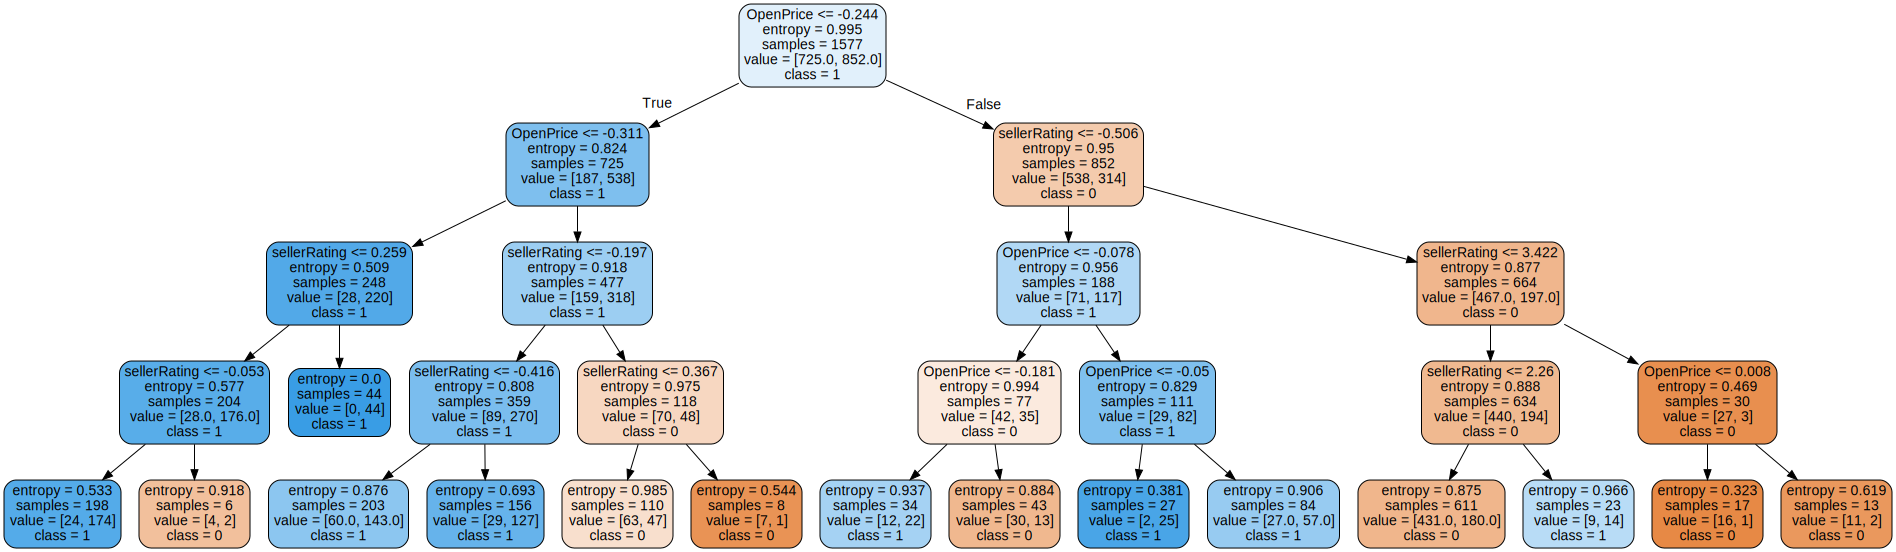

In [ ]:
dot_data = export_graphviz(
    best_dt,
    feature_names=usable_features,
    class_names=class_names,
    rounded=True,
    filled=True
)

# Visualize in Colab
graph = graphviz.Source(dot_data)
graph.render("fullClassTree_tuned")  # saves PDF by default
graph  # display inline

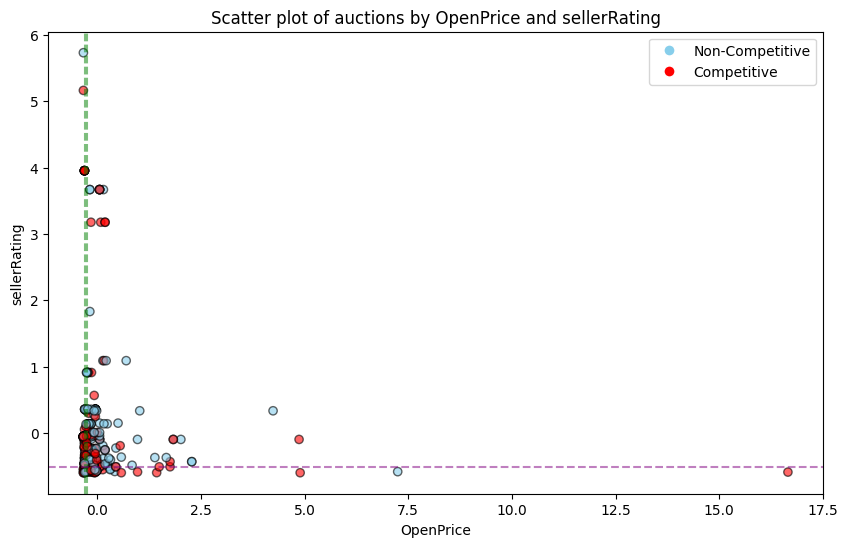

In [ ]:
## Scatter plot using the two best quantitative predictors
x_var = 'OpenPrice'
y_var = 'sellerRating'

X_plot = X_test_tuned[[x_var, y_var]]
y_plot = y_test

colors = ['red' if c == 1 else 'skyblue' for c in y_plot]

plt.figure(figsize=(10,6))
plt.scatter(X_plot[x_var], X_plot[y_var], c=colors, alpha=0.6, edgecolors='k')
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title('Scatter plot of auctions by OpenPrice and sellerRating')
plt.legend(handles=[
    plt.Line2D([0],[0], marker='o', color='w', label='Non-Competitive', markerfacecolor='skyblue', markersize=8),
    plt.Line2D([0],[0], marker='o', color='w', label='Competitive', markerfacecolor='red', markersize=8)
])
for x_split in [-0.24, -0.31]:
  plt.axvline(x=x_split, color='green', linestyle='--', alpha=0.5)

plt.axhline(y=-0.51, color='purple', linestyle='--', alpha=0.5)

plt.show()